In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import scipy.stats as stats
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.transformations import log_transform_column, sqrt_transform_column
from src.outlier_handling import winsorize_column, remove_outliers_zscore, remove_outliers_iqr
from src.data_preprocessing import fill_numeric_missing_values, fill_categorical_missing_values
from src.user_overview_analysis import get_top_10_handsets, get_top_3_manufacturers, get_top_5_handsets_per_manufacturer
from src.data_aggregation import aggregate_user_data
from src.eda import describe_variables, segment_users_by_duration, compute_basic_metrics, compute_dispersion_parameters, plot_univariate_analysis, plot_bivariate_analysis, compute_correlation_matrix, perform_pca
from src.visualization import plot_histograms, plot_boxplots, plot_scatter

In [2]:
DATABASE_TYPE = 'postgresql'
DBAPI = 'psycopg2'
HOST = 'localhost'
PORT = '5432'
DATABASE = 'Week2'
USER = 'postgres'
PASSWORD = '183153'

In [3]:
engine = create_engine(f'{DATABASE_TYPE}+{DBAPI}://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}')

In [4]:
query = "SELECT * FROM xdr_data;"
data = pd.read_sql(query, engine)

In [5]:
data.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [7]:
data.describe()

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
count,1.490100e+05,150000.000000,150000.000000,1.500000e+05,1.494310e+05,1.489350e+05,1.494290e+05,122172.000000,122189.000000,150000.000000,...,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500010e+05,1.500000e+05,1.500000e+05
mean,1.013887e+19,499.188200,498.800880,1.046086e+05,2.082016e+14,4.188282e+10,4.847455e+13,109.795706,17.662883,13300.045927,...,1.163407e+07,1.100941e+07,1.162685e+07,1.100175e+07,4.220447e+08,8.288398e+06,4.211005e+08,8.264799e+06,4.112121e+07,4.546434e+08
std,2.893173e+18,288.611834,288.097653,8.103762e+04,2.148809e+10,2.447443e+12,2.241637e+13,619.782739,84.793524,23971.878541,...,6.710569e+06,6.345423e+06,6.725218e+06,6.359490e+06,2.439675e+08,4.782700e+06,2.432050e+08,4.769004e+06,1.127639e+07,2.441429e+08
min,6.917538e+18,0.000000,0.000000,7.142000e+03,2.040471e+14,3.360100e+10,4.400152e+11,0.000000,0.000000,0.000000,...,5.300000e+01,1.050000e+02,4.200000e+01,3.500000e+01,2.516000e+03,5.900000e+01,3.290000e+03,1.480000e+02,2.866892e+06,7.114041e+06
25%,7.349883e+18,250.000000,251.000000,5.744050e+04,2.082014e+14,3.365130e+10,3.546071e+13,32.000000,2.000000,43.000000,...,5.833501e+06,5.517965e+06,5.777156e+06,5.475981e+06,2.104733e+08,4.128476e+06,2.101869e+08,4.145943e+06,3.322201e+07,2.431068e+08
50%,7.349883e+18,499.000000,500.000000,8.639900e+04,2.082015e+14,3.366371e+10,3.572201e+13,45.000000,5.000000,63.000000,...,1.161602e+07,1.101345e+07,1.164222e+07,1.099638e+07,4.234081e+08,8.291208e+06,4.218030e+08,8.267071e+06,4.114331e+07,4.558411e+08
75%,1.304243e+19,749.000000,750.000000,1.324302e+05,2.082018e+14,3.368349e+10,8.611970e+13,70.000000,15.000000,19710.750000,...,1.744852e+07,1.651556e+07,1.747048e+07,1.650727e+07,6.331742e+08,1.243162e+07,6.316918e+08,1.238415e+07,4.903424e+07,6.657055e+08
max,1.318654e+19,999.000000,999.000000,1.859336e+06,2.140743e+14,8.823971e+14,9.900120e+13,96923.000000,7120.000000,378160.000000,...,2.325910e+07,2.201196e+07,2.325919e+07,2.201196e+07,8.434419e+08,1.655879e+07,8.434425e+08,1.655882e+07,7.833131e+07,9.029696e+08


In [8]:
data[data.isnull()].sum()

Bearer Id                                   0.0
Start                                         0
Start ms                                    0.0
End                                           0
End ms                                      0.0
Dur. (ms)                                   0.0
IMSI                                        0.0
MSISDN/Number                               0.0
IMEI                                        0.0
Last Location Name                            0
Avg RTT DL (ms)                             0.0
Avg RTT UL (ms)                             0.0
Avg Bearer TP DL (kbps)                     0.0
Avg Bearer TP UL (kbps)                     0.0
TCP DL Retrans. Vol (Bytes)                 0.0
TCP UL Retrans. Vol (Bytes)                 0.0
DL TP < 50 Kbps (%)                         0.0
50 Kbps < DL TP < 250 Kbps (%)              0.0
250 Kbps < DL TP < 1 Mbps (%)               0.0
DL TP > 1 Mbps (%)                          0.0
UL TP < 10 Kbps (%)                     

## as we can see from the above result there is no missing value for each columns 

In [9]:
data['Start'] = pd.to_datetime(data['Start'], format='%m/%d/%Y %H:%M')
data['End'] = pd.to_datetime(data['End'], format='%m/%d/%Y %H:%M')
data.head()
data["Start"].dtype


dtype('<M8[ns]')

In [10]:
 numerical_columns = data.select_dtypes(include='number')
numerical_columns

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,770.0,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,42.0,5.0,23.0,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,2.780823e+08,1.434415e+07,1.717444e+08,8.814393e+06,36749741.0,308879636.0
1,1.311448e+19,235.0,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,65.0,5.0,16.0,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,6.087501e+08,1.170709e+06,5.269042e+08,1.505514e+07,53800391.0,653384965.0
2,1.311448e+19,1.0,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,NaN,NaN,6.0,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,2.295846e+08,3.956300e+05,4.106926e+08,4.215763e+06,27883638.0,279807335.0
3,1.311448e+19,486.0,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,NaN,NaN,44.0,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,7.995382e+08,1.084972e+07,7.490399e+08,1.279728e+07,43324218.0,846028530.0
4,1.311448e+19,565.0,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,NaN,NaN,6.0,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,5.277072e+08,3.529801e+06,5.507095e+08,1.391032e+07,38542814.0,569138589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,451.0,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,32.0,0.0,52.0,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,483.0,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,27.0,2.0,23.0,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,283.0,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,43.0,6.0,43.0,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,696.0,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,37.0,5.0,34.0,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0


In [11]:
skewness = numerical_columns.skew()

In [12]:
skewness

Bearer Id                                     0.026666
Start ms                                      0.000968
End ms                                       -0.001163
Dur. (ms)                                     3.952609
IMSI                                         41.045956
MSISDN/Number                               332.155856
IMEI                                          1.071470
Avg RTT DL (ms)                              62.907828
Avg RTT UL (ms)                              28.457415
Avg Bearer TP DL (kbps)                       2.589437
Avg Bearer TP UL (kbps)                       4.503413
TCP DL Retrans. Vol (Bytes)                  15.951809
TCP UL Retrans. Vol (Bytes)                  84.113393
DL TP < 50 Kbps (%)                          -2.297803
50 Kbps < DL TP < 250 Kbps (%)                3.271453
250 Kbps < DL TP < 1 Mbps (%)                 4.566158
DL TP > 1 Mbps (%)                            5.370351
UL TP < 10 Kbps (%)                          -8.985016
10 Kbps < 

In [13]:
high_skew_cols = ['MSISDN/Number', 'IMSI', 'TCP DL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']
log_transform_cols = ['MSISDN/Number', 'IMSI', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Total UL (Bytes)', 'Total DL (Bytes)']
sqrt_transform_cols = ['UL TP < 10 Kbps (%)', 'Gaming DL (Bytes)', 'Social Media DL (Bytes)']
zscore_cols = ['TCP DL Retrans. Vol (Bytes)', 'HTTP DL (Bytes)', 'HTTP UL (Bytes)']
iqr_cols = ['UL TP < 10 Kbps (%)', 'Gaming DL (Bytes)', 'Social Media DL (Bytes)']


In [14]:
def process_outliers(data, high_skew_cols, log_transform_cols, sqrt_transform_cols, zscore_cols, iqr_cols):
    for col in high_skew_cols:
        data[col] = winsorize_column(data[col])
    
    for col in log_transform_cols:
        data[col] = log_transform_column(data[col])
    
    for col in sqrt_transform_cols:
        data[col] = sqrt_transform_column(data[col])
    
    for col in zscore_cols:
        data = remove_outliers_zscore(data, col)
    
    for col in iqr_cols:
        data[col] = remove_outliers_iqr(data[col])
    
    return data


In [15]:
processed_data = process_outliers(data, high_skew_cols, log_transform_cols, sqrt_transform_cols, zscore_cols, iqr_cols)

In [16]:
processed_data.dtypes

Bearer Id                                          float64
Start                                       datetime64[ns]
Start ms                                           float64
End                                         datetime64[ns]
End ms                                             float64
Dur. (ms)                                          float64
IMSI                                               float64
MSISDN/Number                                      float64
IMEI                                               float64
Last Location Name                                  object
Avg RTT DL (ms)                                    float64
Avg RTT UL (ms)                                    float64
Avg Bearer TP DL (kbps)                            float64
Avg Bearer TP UL (kbps)                            float64
TCP DL Retrans. Vol (Bytes)                        float64
TCP UL Retrans. Vol (Bytes)                        float64
DL TP < 50 Kbps (%)                                float

## After applying a transformation and removing outliers, the dataset contain missing values, even though it appeared clean initially. This occurs because transformations such as scaling or logarithmic changes can introduce NaN values in cases where the original data contained extreme values or zeros that the transformation cannot handle. Additionally, during outlier removal, when extreme values are excluded, it might leave gaps in the data that show up as missing values.

In [17]:
data = fill_categorical_missing_values(processed_data)
data = fill_numeric_missing_values(processed_data)

In [18]:
data.isnull().sum()

Bearer Id                                   0
Start                                       1
Start ms                                    0
End                                         1
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

In [19]:
data["End"].unique()

<DatetimeArray>
['2019-04-25 14:35:00', '2019-04-25 08:15:00', '2019-04-25 11:58:00',
 '2019-04-25 07:36:00', '2019-04-25 10:40:00', '2019-04-25 08:08:00',
 '2019-04-25 08:16:00', '2019-04-25 02:26:00', '2019-04-25 10:22:00',
 '2019-04-25 00:40:00',
 ...
 '2019-04-30 21:12:00', '2019-04-30 22:34:00', '2019-04-30 23:03:00',
 '2019-04-30 19:33:00', '2019-04-30 22:21:00', '2019-04-30 22:48:00',
 '2019-04-30 23:41:00', '2019-04-30 23:18:00', '2019-04-30 22:32:00',
                 'NaT']
Length: 6404, dtype: datetime64[ns]

In [20]:
def get_index(data):
    index = []
    for i, value in enumerate(data["End"]):
        if pd.isna(value):
            index.append(i)
    data = data.drop(index, axis=0).reset_index(drop=True)
    return data,index

data,index = get_index(data)

In [21]:
index

[148232]

In [22]:
data

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,2019-04-04 12:01:00,770.000000,2019-04-25 14:35:00,662.000000,1.823652e+06,32.969527,24.239723,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,16675.799921,1.434415e+07,1.717444e+08,8.814393e+06,17.419642,19.548462
1,1.311448e+19,2019-04-09 13:04:00,235.000000,2019-04-25 08:15:00,606.000000,1.365104e+06,32.969529,24.240225,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,24672.861083,1.170709e+06,5.269042e+08,1.505514e+07,17.800791,20.297677
2,1.311448e+19,2019-04-09 17:42:00,1.000000,2019-04-25 11:58:00,652.000000,1.361762e+06,32.969522,24.242561,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,15152.050059,3.956300e+05,4.106926e+08,4.215763e+06,17.143551,19.449612
3,1.311448e+19,2019-04-10 00:31:00,486.000000,2019-04-25 07:36:00,171.000000,1.321509e+06,32.969527,24.242256,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,28276.105690,1.084972e+07,7.490399e+08,1.279728e+07,17.584222,20.556064
4,1.311448e+19,2019-04-12 20:10:00,565.000000,2019-04-25 10:40:00,954.000000,1.089009e+06,32.969527,24.240758,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,22971.879505,3.529801e+06,5.507095e+08,1.391032e+07,17.467280,20.159635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148227,7.277826e+18,2019-04-29 07:28:00,451.000000,2019-04-30 06:02:00,214.000000,8.123000e+04,32.969531,24.239299,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,22947.977536,9.197207e+06,3.264510e+06,1.348742e+07,17.869534,20.168445
148228,7.349883e+18,2019-04-29 07:28:00,483.000000,2019-04-30 10:41:00,187.000000,9.797000e+04,32.969529,24.239679,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,25037.832614,4.735033e+06,7.121804e+08,2.457758e+06,17.482530,20.317774
148229,1.311448e+19,2019-04-29 07:28:00,283.000000,2019-04-30 10:46:00,810.000000,9.824900e+04,32.969528,24.238443,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,23527.419833,1.339432e+07,1.211009e+08,1.131473e+07,17.368348,20.200345
148230,1.311448e+19,2019-04-29 07:28:00,696.000000,2019-04-30 10:40:00,327.000000,9.791000e+04,32.969530,24.238376,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,18775.967911,2.529475e+06,8.147131e+08,1.406930e+06,17.204166,19.734125


In [23]:
data=data.drop(index=148231,axis=0)

In [24]:
data.isnull().sum()

Bearer Id                                   0
Start                                       0
Start ms                                    0
End                                         0
End ms                                      0
Dur. (ms)                                   0
IMSI                                        0
MSISDN/Number                               0
IMEI                                        0
Last Location Name                          0
Avg RTT DL (ms)                             0
Avg RTT UL (ms)                             0
Avg Bearer TP DL (kbps)                     0
Avg Bearer TP UL (kbps)                     0
TCP DL Retrans. Vol (Bytes)                 0
TCP UL Retrans. Vol (Bytes)                 0
DL TP < 50 Kbps (%)                         0
50 Kbps < DL TP < 250 Kbps (%)              0
250 Kbps < DL TP < 1 Mbps (%)               0
DL TP > 1 Mbps (%)                          0
UL TP < 10 Kbps (%)                         0
10 Kbps < UL TP < 50 Kbps (%)     

## The dataset has been thoroughly cleaned and preprocessed, with all missing values, outliers, and skewed data successfully removed. At this stage, the data is now in a suitable condition for further analysis. We can proceed confidently to the next steps in the data processing pipeline, focusing on in-depth analysis, feature engineering, or model development as needed.

In [25]:
top_10_handsets = get_top_10_handsets(data)

In [26]:
top_10_handsets

Handset Type
Huawei B528S-23A                18999
Apple iPhone 6S (A1688)          9400
Apple iPhone 6 (A1586)           8995
undefined                        8972
Apple iPhone 7 (A1778)           6308
Apple iPhone Se (A1723)          5180
Apple iPhone 8 (A1905)           4983
Apple iPhone Xr (A2105)          4554
Samsung Galaxy S8 (Sm-G950F)     4511
Apple iPhone X (A1901)           3810
Name: count, dtype: int64

In [27]:
top_3_manufacturers = get_top_3_manufacturers(data)

In [28]:
top_3_manufacturers

Handset Manufacturer
Apple      59989
Samsung    40757
Huawei     32930
Name: count, dtype: int64

In [29]:
top_5_handsets_per_manufacturer = get_top_5_handsets_per_manufacturer(data, top_3_manufacturers)

In [30]:
for manufacturer, handsets in top_5_handsets_per_manufacturer.items():
    print(f'manufacturer:{manufacturer}')
    print(f'handsets:{handsets}')

manufacturer:Apple
handsets:Handset Type
Apple iPhone 6S (A1688)    9400
Apple iPhone 6 (A1586)     8995
Apple iPhone 7 (A1778)     6308
Apple iPhone Se (A1723)    5180
Apple iPhone 8 (A1905)     4983
Name: count, dtype: int64
manufacturer:Samsung
handsets:Handset Type
Samsung Galaxy S8 (Sm-G950F)    4511
Samsung Galaxy A5 Sm-A520F      3720
Samsung Galaxy J5 (Sm-J530)     3693
Samsung Galaxy J3 (Sm-J330)     3477
Samsung Galaxy S7 (Sm-G930X)    3196
Name: count, dtype: int64
manufacturer:Huawei
handsets:Handset Type
Huawei B528S-23A                  18432
Huawei P20 Lite Huawei Nova 3E     2017
Huawei E5180                       1989
Huawei P20                         1479
Huawei Y6 2018                      995
Name: count, dtype: int64


## Marketing Recommendations:
### Focus on Top Handsets: Target marketing campaigns around the most popular handsets, as they are already preferred by users.
### Partner with Manufacturers: Collaborate with the top 3 manufacturers to launch joint campaigns or exclusive offers.
### Tailored Offers: Offer promotions, discounts, or exclusive services for users of the top 10 handsets.
    

In [31]:
data

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,2019-04-04 12:01:00,770.0,2019-04-25 14:35:00,662.0,1823652.0,32.969527,24.239723,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,16675.799921,14344150.0,171744450.0,8814393.0,17.419642,19.548462
1,1.311448e+19,2019-04-09 13:04:00,235.0,2019-04-25 08:15:00,606.0,1365104.0,32.969529,24.240225,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,24672.861083,1170709.0,526904238.0,15055145.0,17.800791,20.297677
2,1.311448e+19,2019-04-09 17:42:00,1.0,2019-04-25 11:58:00,652.0,1361762.0,32.969522,24.242561,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,15152.050059,395630.0,410692588.0,4215763.0,17.143551,19.449612
3,1.311448e+19,2019-04-10 00:31:00,486.0,2019-04-25 07:36:00,171.0,1321509.0,32.969527,24.242256,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,28276.105690,10849722.0,749039933.0,12797283.0,17.584222,20.556064
4,1.311448e+19,2019-04-12 20:10:00,565.0,2019-04-25 10:40:00,954.0,1089009.0,32.969527,24.240758,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,22971.879505,3529801.0,550709500.0,13910322.0,17.467280,20.159635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148226,1.304243e+19,2019-04-29 07:28:00,615.0,2019-04-30 00:01:00,407.0,59587.0,32.969527,24.239833,3.533251e+13,T85721A,...,6550499.0,18003146.0,22468983.0,7149728.0,28007.773046,12724751.0,321383162.0,14890486.0,17.799769,20.523615
148227,7.277826e+18,2019-04-29 07:28:00,451.0,2019-04-30 06:02:00,214.0,81230.0,32.969531,24.239299,3.548311e+13,D20434A,...,16191667.0,11763428.0,17883703.0,19678161.0,22947.977536,9197207.0,3264510.0,13487416.0,17.869534,20.168445
148228,7.349883e+18,2019-04-29 07:28:00,483.0,2019-04-30 10:41:00,187.0,97970.0,32.969529,24.239679,3.566051e+13,D10223C,...,13877234.0,8288284.0,19350146.0,21293148.0,25037.832614,4735033.0,712180387.0,2457758.0,17.482530,20.317774
148229,1.311448e+19,2019-04-29 07:28:00,283.0,2019-04-30 10:46:00,810.0,98249.0,32.969528,24.238443,3.572121e+13,T51102A,...,22660510.0,1855903.0,9963942.0,5065760.0,23527.419833,13394316.0,121100856.0,11314729.0,17.368348,20.200345


In [32]:
user_aggregates = aggregate_user_data(data)

In [33]:
user_aggregates

,number_of_sessions,total_duration,total_http_dl,total_http_ul,total_social_media_dl,total_social_media_ul,total_youtube_dl,total_youtube_ul,total_netflix_dl,total_netflix_ul,...,total_google_ul,total_email_dl,total_email_ul,total_gaming_dl,total_gaming_ul,total_other_dl,total_other_ul,total_dl,total_ul,total_data_volume
MSISDN/Number,,,,,,,,,,,,,,,,,,,,,
24.237907,1488,152161627.0,20406.990375,17475.141610,1.883456e+06,48289351.0,1.687647e+10,1.640713e+10,1.694210e+10,1.628340e+10,...,3.081532e+09,2.683873e+09,694785942.0,2.882790e+07,1.198958e+10,6.088141e+11,1.216504e+10,29337.378277,26009.294346,55346.672623
24.237907,1,82634.0,14.116787,12.042087,6.452852e+02,49293.0,2.199320e+07,7.167141e+06,1.818765e+07,9.070681e+06,...,1.123005e+06,1.575576e+06,264032.0,1.518428e+04,1.074903e+07,2.450867e+08,2.846045e+06,19.424738,17.258145,36.682883
24.237907,2,223517.0,28.233573,24.084174,1.685413e+03,96011.0,4.926004e+06,7.964428e+06,3.746501e+07,7.077778e+06,...,4.145196e+06,2.885703e+06,984045.0,4.993315e+04,1.815323e+07,1.737803e+08,2.041643e+07,40.573756,34.363837,74.937593
24.237907,2,77490.0,25.478331,21.027157,3.007232e+03,19455.0,1.411210e+07,2.733636e+07,2.497914e+07,1.882330e+07,...,5.802549e+06,4.695443e+06,582040.0,3.475079e+04,1.321719e+07,9.219735e+08,2.101042e+07,38.884100,35.162490,74.046590
24.237907,1,86400.0,12.254139,11.345619,1.432924e+03,26297.0,6.247453e+06,2.001153e+07,9.740948e+06,7.385547e+06,...,1.876626e+06,1.565637e+06,919842.0,2.899342e+04,7.364420e+05,3.552715e+08,9.745060e+06,20.584744,17.521772,38.106516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24.243256,1,100767.0,14.116787,12.042087,1.545495e+03,87.0,1.852288e+07,1.639111e+07,1.706513e+06,2.423849e+06,...,1.517616e+06,5.154680e+05,581407.0,2.633995e+04,6.636192e+06,3.784546e+08,3.440290e+05,20.403814,17.143932,37.547747
24.243256,1,170959.0,14.116787,12.042087,1.662122e+03,55801.0,4.027312e+06,7.681157e+06,1.152079e+07,1.479191e+07,...,3.819309e+06,5.204700e+04,790207.0,2.011590e+04,1.654985e+07,6.212396e+08,1.052226e+06,19.865613,17.616389,37.482002
24.243256,1,37368.0,6.931472,7.438972,6.467836e+02,29134.0,7.163679e+06,1.206369e+07,3.521870e+05,1.476608e+07,...,3.916344e+06,5.868200e+04,195938.0,1.123008e+04,3.604033e+06,8.916637e+07,6.823174e+06,18.752232,17.538753,36.290985


In [34]:
# Segment users and compute total data per decile
total_data_per_decile = segment_users_by_duration(data, user_aggregates)

In [36]:
describe_variables(user_aggregates)

<class 'pandas.core.frame.DataFrame'>
Index: 103863 entries, 24.237906833977522 to 24.24325619249731
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   number_of_sessions     103863 non-null  int64  
 1   total_duration         103863 non-null  float64
 2   total_http_dl          103863 non-null  float64
 3   total_http_ul          103863 non-null  float64
 4   total_social_media_dl  103863 non-null  float64
 5   total_social_media_ul  103863 non-null  float64
 6   total_youtube_dl       103863 non-null  float64
 7   total_youtube_ul       103863 non-null  float64
 8   total_netflix_dl       103863 non-null  float64
 9   total_netflix_ul       103863 non-null  float64
 10  total_google_dl        103863 non-null  float64
 11  total_google_ul        103863 non-null  float64
 12  total_email_dl         103863 non-null  float64
 13  total_email_ul         103863 non-null  float64
 14  total_gaming_

In [37]:
compute_basic_metrics(user_aggregates)

,number_of_sessions,total_duration,total_http_dl,total_http_ul,total_social_media_dl,total_social_media_ul,total_youtube_dl,total_youtube_ul,total_netflix_dl,total_netflix_ul,...,total_google_ul,total_email_dl,total_email_ul,total_gaming_dl,total_gaming_ul,total_other_dl,total_other_ul,total_dl,total_ul,total_data_volume
count,103863.000000,1.038630e+05,103863.000000,103863.000000,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,...,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,1.038630e+05,103863.000000,103863.000000,103863.000000
mean,1.427178,1.496342e+05,20.147169,17.186203,1.803317e+03,4.699662e+04,1.660621e+07,1.571332e+07,1.659080e+07,1.569909e+07,...,2.934920e+06,2.556833e+06,6.669044e+05,2.764242e+04,1.182590e+07,6.008612e+08,1.179636e+07,28.139032,24.960542,53.099573
std,7.336818,7.382912e+05,100.052526,85.845624,9.238191e+03,2.398698e+05,8.493315e+07,8.134502e+07,8.474132e+07,8.091168e+07,...,1.538786e+07,1.328298e+07,3.451811e+06,1.416705e+05,6.043074e+07,3.091967e+09,6.067959e+07,144.591259,128.313456,272.903099
min,1.000000,7.142000e+03,5.153292,6.102559,3.464102e+00,0.000000e+00,5.300000e+01,1.060000e+02,4.200000e+01,3.500000e+01,...,3.000000e+00,9.700000e+01,1.400000e+01,5.015974e+01,5.900000e+01,3.290000e+03,1.560000e+02,15.993335,14.868739,33.019835
25%,1.000000,7.115450e+04,14.116787,12.042087,1.100460e+03,2.158200e+04,7.639428e+06,7.233771e+06,7.570016e+06,7.189048e+06,...,1.337414e+06,1.182505e+06,3.053615e+05,1.694787e+04,5.430656e+06,2.761271e+08,5.455438e+06,19.598868,17.408947,37.036188
50%,1.000000,1.027950e+05,14.116787,12.042087,1.548047e+03,4.151100e+04,1.458503e+07,1.383644e+07,1.461798e+07,1.385711e+07,...,2.587066e+06,2.261348e+06,5.857640e+05,2.372632e+04,1.043118e+07,5.289758e+08,1.036427e+07,20.233625,17.662410,37.717317
75%,2.000000,1.727990e+05,24.032301,20.525516,1.878761e+03,5.983700e+04,2.109945e+07,1.994092e+07,2.110265e+07,1.997342e+07,...,3.737782e+06,3.244514e+06,8.511600e+05,2.879627e+04,1.505568e+07,7.641496e+08,1.500154e+07,37.956673,34.425273,72.842957
max,1488.000000,1.576267e+08,20406.990375,17493.352711,1.883456e+06,4.828935e+07,1.723894e+10,1.640713e+10,1.726671e+10,1.628340e+10,...,3.131156e+09,2.693505e+09,7.011784e+08,2.882790e+07,1.241055e+10,6.432865e+11,1.216504e+10,29337.378277,26009.294346,55346.672623


In [38]:
compute_dispersion_parameters(user_aggregates)

,total_duration,total_dl,total_ul
mean,1.496342e+05,28.139032,24.960542
std,7.382912e+05,144.591259,128.313456
var,5.450738e+11,20906.632115,16464.342999


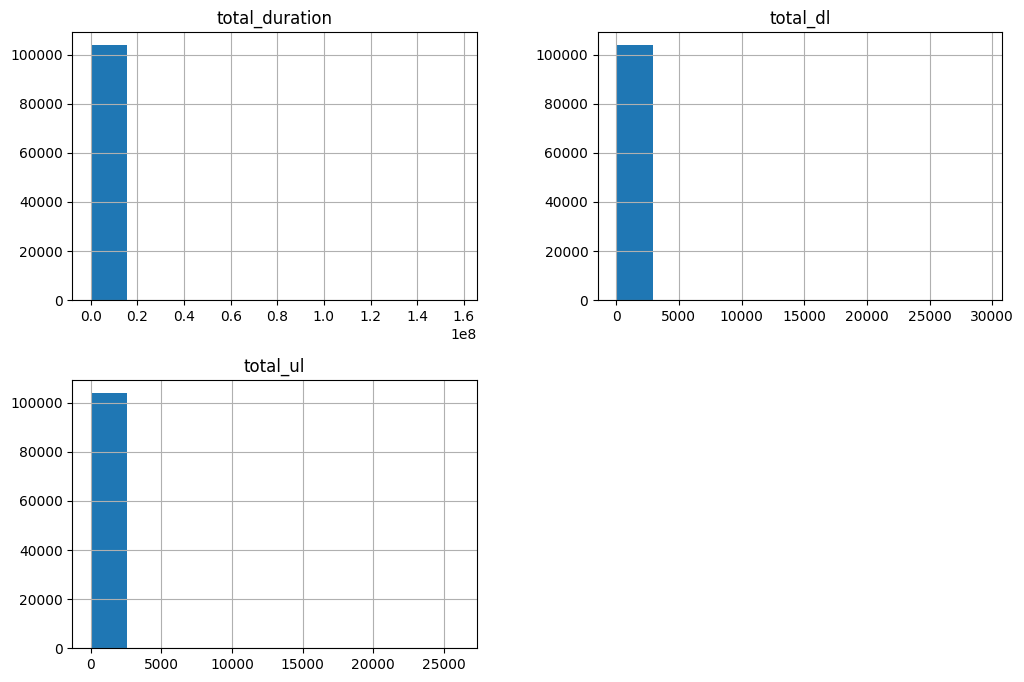

In [39]:
plot_histograms(user_aggregates, ['total_duration', 'total_dl', 'total_ul'])

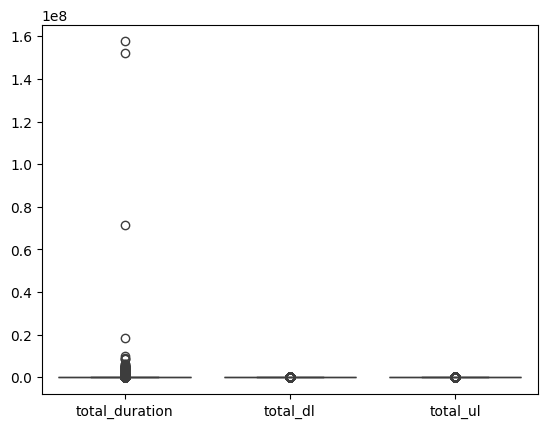

In [40]:
plot_boxplots(user_aggregates, ['total_duration', 'total_dl', 'total_ul'])

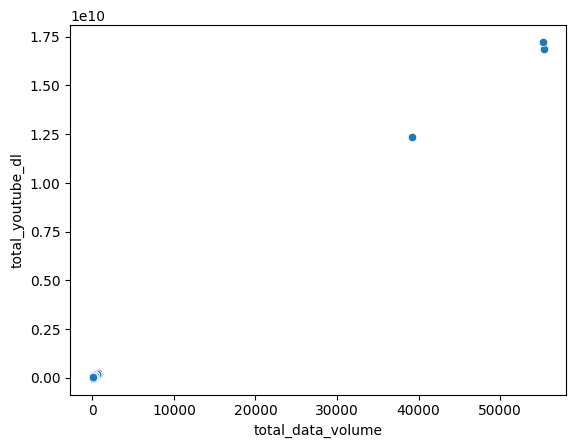

In [41]:
plot_scatter(user_aggregates, 'total_data_volume', 'total_youtube_dl')

In [42]:
compute_correlation_matrix(user_aggregates)

,total_social_media_dl,total_google_dl,total_email_dl,total_youtube_dl,total_netflix_dl,total_gaming_dl,total_other_dl
total_social_media_dl,1.000000,0.994054,0.994085,0.993848,0.993862,0.996758,0.993491
total_google_dl,0.994054,1.000000,0.991469,0.991100,0.991169,0.994028,0.990874
total_email_dl,0.994085,0.991469,1.000000,0.991320,0.991354,0.994011,0.991191
total_youtube_dl,0.993848,0.991100,0.991320,1.000000,0.991247,0.993868,0.991141
total_netflix_dl,0.993862,0.991169,0.991354,0.991247,1.000000,0.993866,0.991093
total_gaming_dl,0.996758,0.994028,0.994011,0.993868,0.993866,1.000000,0.993463
total_other_dl,0.993491,0.990874,0.991191,0.991141,0.991093,0.993463,1.000000


In [43]:
pca_df, explained_variance, components = perform_pca(user_aggregates)

In [48]:
print(f"Explained variance ratio: {explained_variance}")

Explained variance ratio: [9.99969791e-01 2.13538894e-05]


In [47]:
print(f"Components:{components}")

Components:[[ 2.96591518e-06  1.34272303e-02  4.25462265e-03  2.72034113e-02
   2.71406566e-02  4.54819605e-05  9.99162131e-01]
 [ 5.29286268e-05  2.56037957e-01  7.46220821e-02  6.80293652e-01
   6.81477829e-01  8.14777529e-04 -4.07916484e-02]]
